In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
%matplotlib inline

In [2]:
# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

## file directory matching diff system distribution
file_str = '.*Mode_data*mode'
file_str_list = list(file_str)
index = 0
for cha in file_str_list:
    if cha == '*':
        file_str_list[index] = os.sep
    index += 1
file_str = ''.join(file_str_list)

In [3]:
# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(file_str+'1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(file_str+'1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(file_str+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)

# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

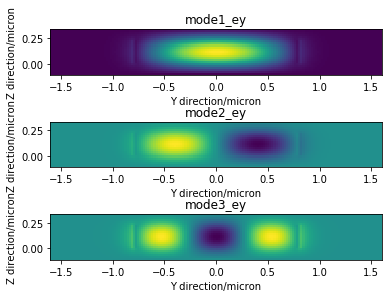

In [4]:
# show three Ey modes
# generate 2d grids for y and z
yy,zz=np.meshgrid(y,z)
plt.figure()
for i in range(num_mode):
    plt.subplot(num_mode, 1, i+1)
    plt.title('mode{}_ey'.format(i+1))
    plt.pcolormesh(yy,zz,mode_data[0][i])
    plt.xlabel("Y direction/micron")
    plt.ylabel("Z direction/micron")
    plt.ylim(-0.11, 0.33)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [5]:
# Synthesis data set

m_base=1000

if False:
    m_all=m_base # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.randn(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=np.abs(rd1)*np.exp(1j*rd2*2*np.pi)
else:
    f = open('.'+os.sep+'training_data_add'+os.sep+'training_data_add_1_111317', 'rb')
    training_data_add_1 = pickle.load(f)
    f.close()

    m_all=m_base+len(training_data_add_1) # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.randn(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=np.abs(rd1)*np.exp(1j*rd2*2*np.pi)
    mode_comp[:,m_base:m_base+len(training_data_add_1)]=np.array(training_data_add_1).T
    
field_sp=[[0+1j for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
mode_comp_label=np.zeros((num_mode,m_all))
for i in range(m_all):
    for j in range(num_mode):
        field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
mode_comp_label=np.abs(mode_comp)**2/np.sum(np.abs(mode_comp)**2,axis=0)

In [6]:
mode_comp_label[:,132]

array([ 0.0961337,  0.1437371,  0.7601292])

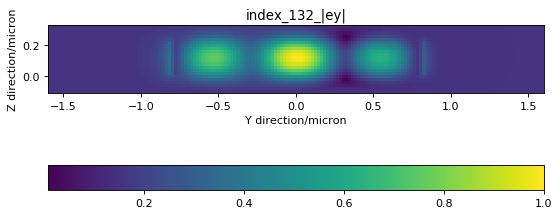

In [7]:
# view specified sample
index=132
plt.figure(num=None, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.title('index_{}_|ey|'.format(index))
plt.pcolormesh(yy,zz,np.abs(field_sp[0][index])/np.max(np.abs(field_sp[0][index])))
plt.xlabel("Y direction/micron")
plt.ylabel("Z direction/micron")
plt.ylim(-0.11, 0.33)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(orientation='horizontal')
plt.show()

In [8]:
# get farfield diffraction pattern
sp_y=y.shape[0] # sampling points along y
sp_z=z.shape[0] # sampling points along z
ff_data=[]
for i in range(m_all):
    ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)

ff_i_data=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data[i]=np.abs(ff_data[i])**2

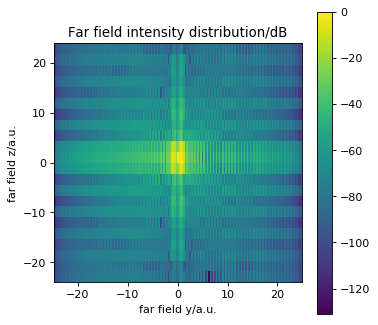

In [9]:
# view specified farfield pattern
sl_y=dy # sampling length(unit) along y
sl_z=dz # sampling length(unit) along z
sf_y=1/dy # sampling frequency along y
sf_z=1/dz # sampling frequency along z
f_y=np.fft.fftshift(np.fft.fftfreq(sp_y,sl_y))
f_z=np.fft.fftshift(np.fft.fftfreq(sp_z,sl_z))
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.pcolormesh(f_y,f_z,10*np.log10(ff_i_data[index]/np.max(ff_i_data[index])))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [10]:
ff_i_data[index].min()

7.1468782310248495e-14

In [11]:
temp_index=np.random.randint(m_all)
ff_i_data_eff_index_0,ff_i_data_eff_index_1=np.nonzero((ff_i_data[temp_index]/np.max(ff_i_data[temp_index]))>=1e-3)
print(ff_i_data_eff_index_0)
print(np.min(ff_i_data_eff_index_0),np.max(ff_i_data_eff_index_0))
print(ff_i_data_eff_index_1)
print(np.min(ff_i_data_eff_index_1),np.max(ff_i_data_eff_index_1))

[10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12
 12 12 12 12 12 12 12]
10 12
[75 76 77 78 79 80 81 82 83 84 75 76 77 78 79 80 81 82 83 84 85 86 75 76 77
 78 79 80 81 82 83 84]
75 86


In [12]:
ff_i_data_eff=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data_eff[i]=ff_i_data[i][9:12,70:91]

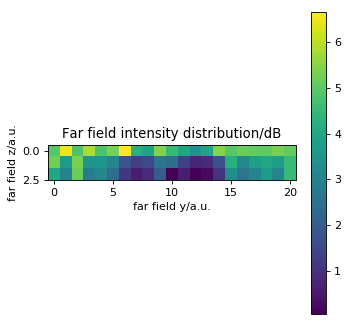

In [13]:
# view specified farfield pattern
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(-np.log10(ff_i_data_eff[index]))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [14]:
np.random.seed(None)
permutation = list(np.random.permutation(m_all))
ff_i_data_eff_shuffled=np.array(ff_i_data_eff)[permutation,:,:]
ff_i_data_eff_shuffled=ff_i_data_eff_shuffled.reshape(m_all,ff_i_data_eff_shuffled.shape[1],
                                                      ff_i_data_eff_shuffled.shape[2],1)
mode_comp_label_shuffled=mode_comp_label[:,permutation]

In [15]:
mode_comp_label.shape

(3, 1190)

In [16]:
X_train = -np.log10(ff_i_data_eff_shuffled[:900,:,:,:])
Y_train = mode_comp_label_shuffled[:,:900].T
X_test = -np.log10(ff_i_data_eff_shuffled[900:,:,:,:])
Y_test = mode_comp_label_shuffled[:,900:].T

In [17]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [18]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [19]:
def build_graph(learning_rate):

    m = X_train.shape[0]
    
    x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1],X_train.shape[2],1])
    y_ = tf.placeholder(tf.float32, shape=[None, Y_train.shape[-1]])
    
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([3, 3, 1, 16]) # [filter_height, filter_width, in_channels, out_channels]
        b_conv1 = bias_variable([16])
        h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1) # [batch, 3, 21, 16]
        h_pool1 = max_pool_2x2(h_conv1) # [batch, 2, 11, 16]
    
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([3, 3, 16, 32])
        b_conv2 = bias_variable([32])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # [batch, 2, 11, 32]
        h_pool2 = max_pool_2x2(h_conv2) # [batch, 1, 6, 32]
        h_pool2_flat = tf.reshape(h_pool2, [-1, h_pool2.shape[1]*h_pool2.shape[2]*h_pool2.shape[3]])
    
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([np.int(h_pool2_flat.shape[-1]), 64])
        b_fc1 = bias_variable([64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        # dropout
        keep_prob_1 = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob_1)
        
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([64, 32])
        b_fc2 = bias_variable([32])
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
        # dropout
        keep_prob_2 = tf.placeholder(tf.float32)
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob_2)
        
    with tf.name_scope('fc3'):
        W_fc3 = weight_variable([32, 3])
        b_fc3 = bias_variable([3])
        y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
        y = tf.nn.softmax(y_conv)
    cost = tf.reduce_mean(tf.reduce_sum((y-y_)**2,axis=-1))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    return keep_prob_1, keep_prob_2, x, y_, y, cost, optimizer

In [20]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(None)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [21]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 1e-4,
          num_epochs = 1500, minibatch_size = 32, keep_prob_1_value = 1, keep_prob_2_value = 1, model = None, print_cost = True, index = 0):
    
    m = X_train.shape[0]
    
    tf.reset_default_graph()
    
    keep_prob_1, keep_prob_2, x, y_, y, cost, optimizer = build_graph(learning_rate)
    
    costs = []
    
    time_cost = []
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        saver = tf.train.Saver()
        # summary_writer = tf.summary.FileWriter('.'+os.sep+'mc_regr_cnn'+os.sep+'graph', sess.graph)
        
        sess.run(init)
        
        if model != None:
            saver.restore(sess, '.'+os.sep+'mc_regr_cnn'+os.sep+'model_2C2F1S'+os.sep+'model_min_tc_1')
        
        # Do the training loop
        for epoch in range(num_epochs):
            if epoch <= 400 and epoch % 100 ==0:
                time_cost.append(time.time())
                if epoch != 0:
                    time_cost_average = (time_cost[-1]-time_cost[0])/(len(time_cost)-1)/100*(num_epochs-epoch)
                    print("The simulation will be done at: ", time.ctime(time_cost_average+time.time()))
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={keep_prob_1: keep_prob_1_value, keep_prob_2: keep_prob_2_value, 
                                                                            x: minibatch_X, y_: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            if epoch == 0:
                test_cost_min = sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_test, y_: Y_test})
            if epoch % 100 ==0:
                train_cost = sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_train, y_: Y_train})
                test_cost = sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_test, y_: Y_test})
                if test_cost<test_cost_min:
                    test_cost_min=test_cost
                    saved_min_tc_model = saver.save(sess, '.'+os.sep+'mc_regr_cnn'+os.sep+
                                                    'model_2C2F1S'+os.sep+'model_min_tc_'+np.str(index))
                if print_cost == True:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                    print ("Train mean square error:", train_cost)
                    print ("Test mean square error:", test_cost)

            if epoch % 10 == 0:
                costs.append(epoch_cost)  
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        saved_model = saver.save(sess, '.'+os.sep+'mc_regr_cnn'+os.sep+'model_2C2F1S'+os.sep+'model_'+np.str(index))
        print("Trained model has been saved.")
        print ("Train mean square error:", sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_train, y_: Y_train}))
        print ("Test mean square error:", sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_test, y_: Y_test}))
        return costs

In [ ]:
# index: 0, learning_rate = 1e-4, num_epochs = 20000, minibatch_size = 16, keep_prob_1_value=0.9, keep_prob_2_value=0.9
# index: 1, learning_rate = 1e-4, num_epochs = 20000, minibatch_size = 16, keep_prob_1_value=1, keep_prob_2_value=1
# index: 2, learning_rate = 1e-4, num_epochs = 20000, minibatch_size = 16, keep_prob_1_value=0.9, keep_prob_2_value=1
# training_data_add_1_111317, m_all = 1190
# index: 3, learning_rate = 1e-4, num_epochs = 20000, minibatch_size = 16, keep_prob_1_value=1, keep_prob_2_value=1
# index: 4, learning_rate = 1e-4, num_epochs = 10000, minibatch_size = 16, keep_prob_1_value=0.9, keep_prob_2_value=1

In [ ]:
costs = model(X_train, Y_train, X_test, Y_test, learning_rate = 1e-4, num_epochs = 10000, 
              minibatch_size = 16, keep_prob_1_value = 1, keep_prob_2_value = 1, print_cost = True, index = 4)

In [25]:
tf.reset_default_graph()
keep_prob_1, keep_prob_2, x, y_, y, cost, optimizer = build_graph(learning_rate=1e-4)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, '.'+os.sep+'mc_regr_cnn'+os.sep+'model_2C2F1S'+os.sep+'model_min_tc_3')
    print ("Train mean square error:", sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_train, y_: Y_train}))
    print ("Test mean square error:", sess.run(cost,feed_dict={keep_prob_1: 1, keep_prob_2: 1, x: X_test, y_: Y_test}))

INFO:tensorflow:Restoring parameters from .\mc_regr_cnn\model_2C2F1S\model_min_tc_3
Train mean square error: 0.000322197
Test mean square error: 0.000233757
